In [91]:
import matplotlib.pyplot as plt
from PIL import Image 
import numpy as np 
import pandas as pd
from string import ascii_letters
import os
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

# PREPROCESSING THE INGREDIENTS

In [92]:
# need to remove these from ingredients
measurements = (['tablespoon', 'tbsp', 'teaspoon', 'tsp', 'cup', 'pint', 'pt', 
                 'quart', 'qt', 'gallon', 'gal', 'ounce', 'ounc', 'ounces', 'oz', 'fluid', 'fl', 'pound', 
                 'lb', 'liter', 'litre', 'l', 'ml', 'gram', 'g', 'inch', 'diameter', 'meter', 'medium',
                 'grill', 'cm', 'handful', 'size', 'firm', 'cupg', 'cupsg', 'cupsml', 'x', 'little', 'divided',
                 'total', 'more', 'package', 'bag', 'bottle', 'tbspg', 'xxinch', 'box', 'instructions', 'info',
                 'ozg', 'lbg', 'kg'])

DATASET_LIMIT = 5000

In [93]:
is_noun = lambda pos: pos[:2] == 'NN'
stemmer = nltk.stem.PorterStemmer()

all_ingredients = []

def parse_ingredients(row):
    list = eval(row['Cleaned_Ingredients'])
    ingredients = []
    for ingredient in list:
        # removing non-letters
        letter_only = ''.join(l for l in ingredient if l in set(ascii_letters + ' '))
        # tokenizing into words
        tokenized = nltk.word_tokenize(letter_only)
        # remove all except nouns, and remove measurements
        nouns = [word.lower() for (word, pos) in nltk.pos_tag(tokenized) if(pos[:2] == 'NN' or pos[:2] == 'NNS')]
        nouns = [noun for noun in nouns if (noun not in measurements) and (stemmer.stem(noun) not in measurements)]
        if len(tokenized) > 0 and len(nouns) == 0:
            nouns.append(tokenized[-1])
        # add as new row, also add to a full ingredient list as features
        joined = ' '.join(nouns)
        ingredients.append(joined)
        if joined not in all_ingredients:
            all_ingredients.append(joined)
    return ','.join(ingredients)

In [94]:
df = pd.read_csv('data/food.csv')
df = df[df.Image_Name != '#NAME?']
df = df.iloc[:DATASET_LIMIT]

# add column for ingredients that are cleaned and parsed
df['parsed_ingredients'] = df.apply(parse_ingredients, axis=1)

In [95]:
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans 

In [96]:
ingredient_strings = df['parsed_ingredients']
vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split(','))
vectorized_documents = vectorizer.fit_transform(ingredient_strings)

C:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


# Reducing Dimensions using PCA

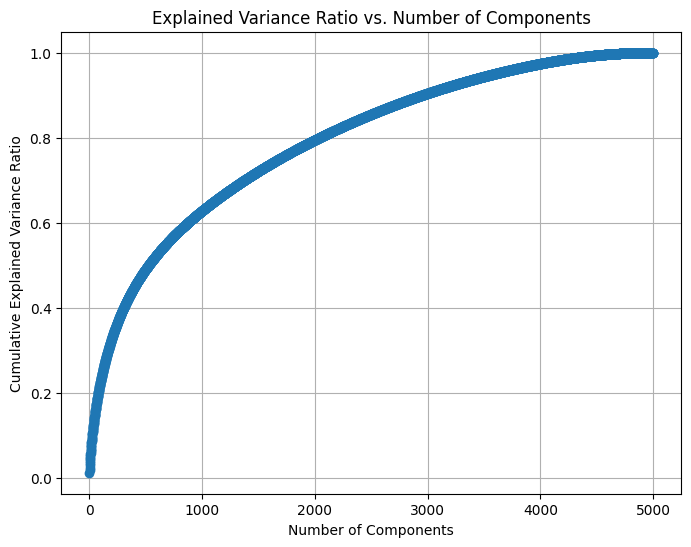

In [98]:
#
# DON'T RUN
# FINDING THE NUMBER OF COMPONENTS
#

pca = PCA()
pca.fit_transform(vectorized_documents.toarray())

# get explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# plot explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(explained_variance_ratio), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.grid(True)
plt.show()

In [99]:
# this is for the dataset of 5000
# if using full dataset, can go between 1500-1750
NUM_COMPONENTS = 900
pca = PCA(n_components=NUM_COMPONENTS)
reduced_ingredients = pca.fit_transform(vectorized_documents.toarray())

In [100]:
all_ingredients = vectorizer.get_feature_names_out()
ingredient_component_mapping = pd.DataFrame(pca.components_, columns=all_ingredients)
print(ingredient_component_mapping)

               abita amber beer     about     above  absinthe  absinthe rinse  \
0    0.000189         -0.000202  0.000778  0.000513 -0.000460       -0.000176   
1   -0.001389         -0.000178 -0.000873 -0.000397 -0.003139       -0.001152   
2   -0.000582          0.000435  0.000502 -0.000512 -0.002570       -0.000786   
3    0.001782          0.000231  0.000635  0.000727  0.001343        0.000472   
4    0.001614          0.001403  0.000142  0.000156 -0.000074        0.000070   
..        ...               ...       ...       ...       ...             ...   
895 -0.008023          0.002619 -0.002396  0.003904  0.000729        0.002348   
896  0.025868         -0.008394 -0.001176 -0.003959  0.009987        0.005177   
897 -0.022786          0.013718 -0.000951  0.001149  0.017499        0.008115   
898  0.028010         -0.005917 -0.002060 -0.003646 -0.028573        0.002734   
899 -0.019226         -0.001601  0.000257 -0.006080  0.003028        0.002585   

     accompaniment baguette

In [129]:
# get the loadings of each principal component
pca_ingredients = []
for i, pc in enumerate(pca.components_):
    index = np.argsort(np.abs(pc))[::-1]
    
    found = False
    i = 0
    while found == False:
        ing = all_ingredients[index[i]]
        if ing in pca_ingredients:
            i += 1
        else:
            pca_ingredients.append(ing)
            found = True

In [101]:
from transformers import CLIPProcessor, CLIPModel
import torch

In [102]:
model_name = "openai/clip-vit-base-patch32"
clip_processor = CLIPProcessor.from_pretrained(model_name)
clip_model = CLIPModel.from_pretrained(model_name)

C:\Users\User\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [103]:
IMAGE_SIZE = (224,224)
clip_model.eval()

def encode_image(image):
    inputs = clip_processor(images=image, return_tensors="pt")
    with torch.no_grad():
        image_features = clip_model.get_image_features(**inputs)

    return image_features

def prepare_image (image):
    img = Image.open (image)
    img = img.resize (IMAGE_SIZE)
    #img = np.expand_dims(img,axis = 0 )
    #img = np.array(img)/255.0
    return img

image_dir = 'data/images/images/'
def process_images(row):
    image_path = image_dir + row['Image_Name'] + '.jpg'
    preprocessed_image = prepare_image(image_path)
    image_features = encode_image(preprocessed_image)
    return image_features

def process_single_image(image_path):
    preprocessed_image = prepare_image(image_path)
    image_features = encode_image(preprocessed_image)
    return image_features

In [104]:
# create CLIP encodings for every image in the df
df['image_encoding'] = df.apply(process_images, axis=1)

In [15]:
print(df.head())
df.to_csv('data/out.csv', index=False)

   Unnamed: 0                                              Title  \
0           0  Miso-Butter Roast Chicken With Acorn Squash Pa...   
1           1                    Crispy Salt and Pepper Potatoes   
2           2                        Thanksgiving Mac and Cheese   
3           3                 Italian Sausage and Bread Stuffing   
4           4                                       Newton's Law   

                                         Ingredients  \
0  ['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher...   
1  ['2 large egg whites', '1 pound new potatoes (...   
2  ['1 cup evaporated milk', '1 cup whole milk', ...   
3  ['1 (¾- to 1-pound) round Italian loaf, cut in...   
4  ['1 teaspoon dark brown sugar', '1 teaspoon ho...   

                                        Instructions  \
0  Pat chicken dry with paper towels, season all ...   
1  Preheat oven to 400°F and line a rimmed baking...   
2  Place a rack in middle of oven; preheat to 400...   
3  Preheat oven to 350°F with 

In [105]:
def compute_target_pca_encoding(ingredients, pca_df):
    target_pca_encoding = np.zeros(NUM_COMPONENTS)
    for ingredient in ingredients:
        if ingredient in pca_df.index:
            max_component_index = pca_df.loc[ingredient].idxmax()
            target_pca_encoding[max_component_index] += pca_df.loc[ingredient, max_component_index]
    
    return torch.tensor(target_pca_encoding, dtype=torch.float32)

# add a new column with pca encodeding for each image
df['target_PCA_encoding'] = [compute_target_pca_encoding(ingredients.split(','), ingredient_component_mapping.T) for ingredients in df['parsed_ingredients']]

# Creating the Dataset

In [106]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split

In [131]:
class InputDataset(Dataset):
    def __init__(self, clip_encodings, pca_components):
        self.clip_encodings = clip_encodings
        self.pca_components = pca_components

    def __len__(self):
        return len(self.clip_encodings)

    def __getitem__(self, idx):
        clip_encoding = self.clip_encodings[idx]
        pca_component = self.pca_components[idx]

        return clip_encoding, pca_component

clip_encodings = df.image_encoding.tolist()
target_pca_components = df.target_PCA_encoding.tolist()
dataset = InputDataset(clip_encodings, target_pca_components)

train_size = int(0.9 * DATASET_LIMIT)
val_size = int(0.1 * DATASET_LIMIT)

train_data, val_data = random_split(dataset, [train_size, val_size])

In [132]:
batch_size = 64

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

# Creating the Model

In [133]:
class CLIPToPCA(nn.Module):
    def __init__(self, clip_input_size, pca_output_size, hidden_size):
        super(CLIPToPCA, self).__init__()
        self.clip_input_size = clip_input_size
        self.pca_output_size = pca_output_size
        self.hidden_size = hidden_size

        self.conv1 = nn.Conv1d(in_channels=clip_input_size, out_channels=hidden_size, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=3, stride=1, padding=1)
        self.output_fc = nn.Linear(hidden_size, pca_output_size)
        self.activation = nn.ReLU()
        
    def forward(self, clip_encodings):
        clip_encodings = clip_encodings.permute(0, 2, 1)
        
        conv_out = self.conv1(clip_encodings)
        conv_out = self.activation(conv_out)
        conv_out = self.conv2(conv_out)
        conv_out = self.activation(conv_out)
        pooled_out = torch.mean(conv_out, dim=2)
        pca_encodings = self.output_fc(pooled_out)
        return pca_encodings

In [134]:
clip_input_size = 512
hidden_size = 128
model = CLIPToPCA(clip_input_size, NUM_COMPONENTS, hidden_size)

learning_rate = 0.0001
num_epochs = 20
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for clip_encodings, pca_components in train_loader:
        optimizer.zero_grad()
        outputs = model(clip_encodings)
        loss = loss_function(outputs, pca_components)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * clip_encodings.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    
    # validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for clip_encodings, pca_components in val_loader:
            outputs = model(clip_encodings)
            loss = loss_function(outputs, pca_components)
            val_loss += loss.item() * clip_encodings.size(0)
    val_loss = val_loss / len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss}, Validation Loss: {val_loss}")

print('Finished Training')

Epoch 1/20, Training Loss: 0.002991169594642189, Validation Loss: 0.0016636986080557107
Epoch 2/20, Training Loss: 0.001346939516150289, Validation Loss: 0.0011243746876716614
Epoch 3/20, Training Loss: 0.0011668382407062584, Validation Loss: 0.0010953190233558415
Epoch 4/20, Training Loss: 0.0011528311787794034, Validation Loss: 0.0010886306390166282
Epoch 5/20, Training Loss: 0.001145359435532656, Validation Loss: 0.0010821716957725585
Epoch 6/20, Training Loss: 0.0011354586674003964, Validation Loss: 0.0010721947862766684
Epoch 7/20, Training Loss: 0.001117436196655035, Validation Loss: 0.0010501868687570095
Epoch 8/20, Training Loss: 0.0010884650215092632, Validation Loss: 0.0010276913428679108
Epoch 9/20, Training Loss: 0.0010675921723143093, Validation Loss: 0.0010169066074304284
Epoch 10/20, Training Loss: 0.0010589544385568134, Validation Loss: 0.0010151415397413074
Epoch 11/20, Training Loss: 0.0010547883882083826, Validation Loss: 0.001012127650436014
Epoch 12/20, Training Lo

In [135]:
new_image_path = image_dir + '3-ingredient-blueberry-champagne-granita.jpg'
new_image_encodings = process_single_image(new_image_path).unsqueeze(0)

In [136]:
model.eval()
with torch.no_grad():
    predicted_encodings = model(new_image_encodings).numpy()

encodings_list = predicted_encodings.flatten().tolist()
encodings_sorted = sorted(range(len(encodings_list)), key=lambda k: encodings_list[k], reverse=True)

top = 20
for i in range(top):
    print(pca_ingredients[encodings_sorted[i]], encodings_list[encodings_sorted[i]])

sugar 0.23340167105197906
kosher salt 0.2249978929758072
oil 0.12967683374881744
salt 0.09948843717575073
cream 0.06740821152925491
butter 0.053599823266267776
cloves 0.048987846821546555
water 0.047818683087825775
sea salt 0.04630902782082558
ground pepper 0.041828446090221405
vanilla extract 0.04148637130856514
onion 0.038449861109256744
wine vinegar 0.03492630645632744
ground cinnamon 0.025787346065044403
parmesan 0.02531992271542549
zest 0.024130433797836304
parsley 0.020935021340847015
orange juice 0.015543199144303799
ginger 0.013872422277927399
wine 0.013726308941841125


# K-MEANS (probably don't need this)

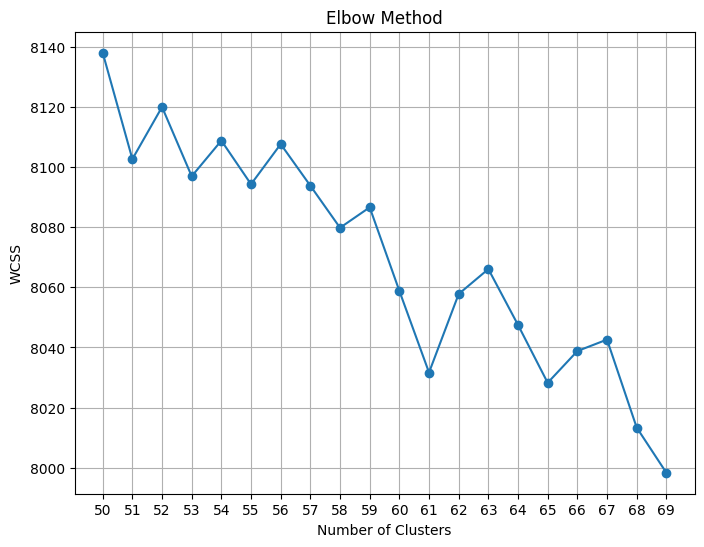

In [31]:
#
# calculate WCSS for different values of k
# DON'T RUN
#
wcss = []
low_range = 1
high_range = 70
for i in range(low_range, high_range):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=50, n_init=10, random_state=0)
    kmeans.fit(reduced_ingredients)
    wcss.append(kmeans.inertia_)

# plot the elbow
plt.figure(figsize=(8, 6))
plt.plot(range(low_range, high_range), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(np.arange(low_range, high_range, 1))
plt.grid(True)
plt.show()

In [15]:
kmeans = KMeans(n_clusters=61, max_iter=300) 
kmeans.fit(reduced_ingredients) 

KMeans(n_clusters=61)